# Welcome to Assignment 3

**TA: [Igor Bogdanov](mailto:igorbogdanov@cmail.carleton.ca)**

## General Instructions:

This Assignment can be done **in a group of two or individually**.

YOU HAVE TO JOIN A GROUP ON BRIGHTSPACE TO SUBMIT.

Please state it explicitly at the beginning of the assignment.

You need only one submission if it's group work.

Please print out values when asked using Python's print() function with f-strings where possible.

Submit your **saved notebook with all the outputs** to Brightspace, but ensure it will produce correct outputs upon restarting and click "runtime" → "run all" with clean outputs. Ensure your notebook displays all answers correctly.

## Your Submission MUST contain your signature at the bottom.

### Objective:
In this assignment, we build a reasoning AI agent that facilitates ML operations and model evaluation. This assignment is heavily based on Tutorial 9.

**Submission:** Submit your Notebook as a *.ipynb* file that adopts this naming convention: ***SYSC4415_W25_A3_NameLastname.ipynb*** on *Brightspace*. No other submission (e.g., through email) will be accepted. (Example file name: SYSC4415_W25_A3_IgorBogdanov.ipynb or SYSC4415_W25_A3_Student1_Student2.ipynb) The notebool MUST contain saved outputs

**Runtime tips:**
Agentic programming and API calling can be easily done locally and moved to Colab in the final stages, depending on the implementation of your tools and ML tasks you want to run.

# Imports

Some basic libraries you need are imported here. Make sure you include whatever library you need in this entire notebook in the code block below.

If you are using any library that requires installation, please paste the installation command here.
Leave the code block below if you are not installing any libraries.

In [ ]:
# Name: Juan Pablo Arango
# Student Number: 101210784

# Name: Jackie Smolkin-Lerner
# Student Number: 101184457

In [ ]:
# Libraries to install - leave this code block blank if this does not apply to you
# Please add a brief comment on why you need the library and what it does
!pip install tensorflow
from keras.datasets import cifar10 # CIFAR-10 image dataset
import tensorflow as tf
from tensorflow.keras import layers, models

# scikit-learn data processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold

import numpy as np
import matplotlib.pyplot as plt

# scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
!pip install groq

# Libraries you might need
# General
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# For pre-processing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# For modeling
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchsummary

# For metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import confusion_matrix

# Agent
from groq import Groq
from dataclasses import dataclass
import re
from typing import Dict, List, Optional


# Task 1: Registration and API Activation (5 marks)

For this particular assignment, we will be using GroqCloud for LLM inference. This task aims to determine how to use the Groq API with LLMs.  

Create a free account on https://groq.com/ and generate an API Key. Don't remove your key until you get your grade. Feel free to delete your API key after the term is completed.

In conversational AI, prompting involves three key roles: the system role (which sets the agent's behavior and capabilities), the user role (which represents human inputs and queries), and the assistant role (which contains the agent's responses). The system role provides the foundational instructions and constraints, the user role delivers the actual queries or commands, and the assistant role generates contextual, step-by-step responses following the system's guidelines. This structured approach ensures consistent, controlled interactions where the agent maintains its defined behavior while responding to user needs, with each role serving a specific purpose in the conversation flow.


In [ ]:
# Q1a (2 mark)
# Create a client using your API key.

API_KEY: str = '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'
client = Groq(api_key=API_KEY)

In [ ]:
# Q1b (3 marks)

# instantiate chat_completion object using model of your choice (llama-3.3-70b-versatile - recommended)
# Hint: Use Tutorial 9 and Groq Documentation
# Explain each parameter and how each value change influences the LLM's output.
# Prompt the model using the user role about anything different from the tutorial.

chat_completion = client.chat.completions.create(
    model="llama-3.3-70b-versatile", # LLM model
    messages=[{"role": "user", "content": "What day is it today?"}], # A user prompt that the model will try to complete
    temperature=0.2, # Sampling temperature: higher values lead to more random output, lower value makes the output more deterministic - higher values are better for creative queries
    # top_p=0.7, # Nucleus sampling, alternate to temperature. Limits the results of tokens that the model considers to a specific probability mass - SHOULD NOT BE USED WITH TEMPERATURE
    max_completion_tokens=1024, # Max number of tokens generated via chat completion - this can be used to limit the size of the output
)

chat_completion.choices[0].message.content

"I'm not currently able to share the time."

# Task 2: Agent Implementation (5 marks)

This task contains an implementation of the agent from Tutorial 9. The idea of this task is to make sure you understand how basic LLM-Agent works.


In [ ]:
# Q2a: (5 marks) Explain how agent implementation works, providing comments line by line.
# This paper might be helpful: https://react-lm.github.io/

@dataclass
class Agent_State:
    messages: List[Dict[str, str]] # this is the agent's current state / the history of all prompts
    system_prompt: str # context of the question

class ML_Agent:
    def __init__(self, system_prompt: str): ## initialize ML agent
        self.client = client # selects model type
        self.state = Agent_State( # Initialize a new agent state with system_prompt
            messages=[{"role": "system", "content": system_prompt}], # The first message should be the system prompt, as this is the agent's context
            system_prompt=system_prompt,
        )

    # Add a new prompt - this will update the state
    # The role can be 'system', for more context, 'user' for queries,
    # or 'assistant"
    def add_message(self, role: str, content: str) -> None:
        self.state.messages.append({"role": role, "content": content})

    # Call the Groq API to prompt the agent with messages from the current agent state
    def execute(self) -> str:
        completion = self.client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            temperature=0.2,
            top_p=0.7,
            max_tokens=1024,
            messages=self.state.messages,
        )
        # Return the response
        return completion.choices[0].message.content

    # Prompt the agent as a user, and add the agent's response
    # as well as the initial prompt to the agent state
    #
    # Return the response
    def __call__(self, message: str) -> str:
        self.add_message("user", message) # Add the user's prompt
        result = self.execute() # Prompt
        self.add_message("assistant", result) # Add the context for the step by step responses
        return result

# Task 3: Tools (20 marks)

Tools are specialized functions that enable AI agents to perform specific actions beyond their inherent capabilities, such as retrieving information, performing calculations, or manipulating data. Agents use tools to decompose complex reasoning into observable steps, extend their knowledge beyond training data, maintain state across interactions, and provide transparency in their decision-making process, ultimately allowing them to solve problems they couldn't tackle through reasoning alone.

Essentially, tools are just callback functions invoked by the agent at the appropriate time during the execution loop.

You need to plan your tools for each particular task your agent is expected to solve.
The Model Evaluation Agent we are building should be able to evaluate the model from the model pool on the specific dataset.

Datasets to use: Penguins, Iris, CIFAR-10

You should be able to tell the agent what to do and watch it display the output of the tools' execution, similar to that in Tutorial 9.

User Prompt examples you should be able to give to your agent and expect it to fulfill the task:
- **Evaluate Linear Regression Model on Iris Dataset**
- **Train a logistic regression model on the Iris dataset**
- **Load the Penguins dataset and preprocess it.**
- **Train a decision tree model on the Penguins dataset and evaluate it.**
- **Load the CIFAR-10 dataset and train Mini-ResNet CNN, visualize results**

Classifier Models for Iris and Penguins (use A1 and early tutorials):
  * Logistic Regression (solver='lbfgs')
  * Decision Tree (max_depth=3)
  * KNN (n_neighbors=5)

Any 2 CNN models of your choice for CIFAR-10 dataset (do some research, don't create anything from scratch unless you want to, use the ones provided by libraries and frameworks)

HINT: It is highly recommended that any code from previous assignments and tutorials be reused for tool implementation.

**Use Pytorch where possible**

## DON'T FORGET TO IMPORT MISSING LIBRARIES

In [ ]:
# Q3a (3 marks): Implement model_memory tool.
# This tool should provide the agent with details about models or datasets
# Example: when asked about Penguin dataset, the agent can use memory to look up
# the source to obtain the dataset.

@dataclass
class DataSet:
  name: str
  data: pd.DataFrame
  X_train: np.ndarray
  y_train: np.ndarray
  X_test: np.ndarray
  y_test: np.ndarray

def model_memory(query: str) -> str:
    """
    Get the details about models or details

    Args:
        query (str): The memory to return

    Returns:
        str: Memory results of the query
    """
    details = {
      'all datasets': 'Penguins,Iris,CIFAR-10',
      'all models': 'logistic_regression:Logistic Regression (solver=\'lbfgs\'), decision_tree:Decision Tree (max_depth=3), knn:KNN (n_neighbors=5), cnn1: ResNet CNN, cnn2: EfficientNet CNN',
    }
    return details.get(query.lower(), f"Invalid query {query}")

In [ ]:
# Q3b (3 marks): Implement dataset_loader tool.
# loads dataset after obtaining info from memory
import pandas as pd
import numpy as np

def dataset_loader(dataset: str) -> str:
  # Global variable for dataset to be loaded into
  global global_dataset

  datasets = {
    'Penguins': 'https://github.com/allisonhorst/palmerpenguins/raw/main/inst/extdata/penguins.csv',
    'Iris': 'https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/raw/master/example-data-science-notebook/iris-data.csv',
    'CIFAR-10': '', # CIFAR-10 loaded directly from keras
  }

  if dataset.lower() == 'cifar-10':
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # Keras CIFAR-10 data is already preprocessed, so we can add it directly to the dataset
    global_dataset = DataSet(
      name = dataset,
      data = None,
      X_train = X_train,
      y_train = y_train,
      X_test = X_test,
      y_test = y_test,
    )
    return f"Dataset CIFAR-10 successfully loaded"


  if dataset not in datasets:
    return f"No dataset with name {dataset}"

  data = pd.read_csv(datasets[dataset])
  global_dataset = DataSet(
    name = dataset,
    data = pd.DataFrame(data),
    X_train = np.array([]),
    y_train = np.array([]),
    X_test = np.array([]),
    y_test = np.array([]),
  )

  rows, cols = global_dataset.data.shape

  return f"Dataset {dataset} successfully loaded with {rows} rows and {cols} cols"

In [ ]:
# Q3c (3 marks): Implement dataset_preprocessing tool.
# preprocesses the dataset to work with the chosen model, and does the splits


def dataset_preprocessing(dataset: str) -> str:
  global global_dataset

  if global_dataset.name == None:
    return f"error: no dataset loaded"

  if global_dataset.name != dataset:
    return f"error: wrong dataset '{global_dataset.name}' loaded"

  elif global_dataset.name.lower() == "penguins":
    penguins = global_dataset.data
    features = penguins.drop(columns=["species"])  # Features (all columns except species)
    labels = penguins["species"]
    penguins_clean = penguins.dropna(
    subset=[
      'species',
      'island',
      'bill_length_mm',
      'bill_depth_mm',
      'flipper_length_mm',
      'body_mass_g',
    ])
    penguins_with_sex = penguins_clean.loc[(penguins_clean['sex'].notnull())]
    features = penguins_with_sex[[
    'bill_length_mm',
    'bill_depth_mm',
    'flipper_length_mm',
    'body_mass_g',
    ]].values
    labels = penguins_with_sex['species'].values

    (X_train, X_test, y_train, y_test) = train_test_split(features,labels, test_size=0.2, random_state=42)

    global_dataset.X_train = StandardScaler().fit_transform(X_train)
    global_dataset.y_train = y_train

    global_dataset.X_test =  StandardScaler().fit_transform(X_test)
    global_dataset.y_test = y_test

  elif global_dataset.name.lower() == "iris":
    iris_data = global_dataset.data
    iris_data.loc[iris_data['class'] == 'versicolor', 'class'] = 'Iris-versicolor'
    iris_data.loc[iris_data['class'] == 'Iris-setossa', 'class'] = 'Iris-setosa'
    average_petal_width = iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].mean()

    # The imputation for only those values that are problematic
    iris_data.loc[(iris_data['class'] == 'Iris-setosa') & # find correct class
                  (iris_data['petal_width_cm'].isnull()), # check that this column val is null
                  'petal_width_cm'] = average_petal_width # fill that column val with avg. imputed value

    # Show the filled in imputed values
    iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
                  (iris_data['petal_width_cm'] == average_petal_width)]
    all_inputs = iris_data[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

    # Similarly, we can extract the class labels
    all_labels = iris_data['class'].values

    (X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, test_size=0.2, random_state=1)

    global_dataset.X_train = StandardScaler().fit_transform(X_train)
    global_dataset.y_train = y_train

    global_dataset.X_test = StandardScaler().fit_transform(X_test)
    global_dataset.y_test = y_test

  elif global_dataset.name.lower() == "cifar-10":
    # Keras CIFAR-10 data already preprocessed during loading
    pass
    # cifar10 = global_dataset.data
    # ((trainX, trainY), (testX, testY)) = cifar10.load_data()
    # trainX = trainX.astype("float") / 255.0
    # testX  = testX.astype("float") / 255.0
  else:
    # Unable to match dataset
    return f"error: preprocessing not supported for '{global_dataset.name}' dataset"

  return f"'{global_dataset.name}' dataset successfully preprocessed"


In [ ]:
# Q3d (3 points): Implement train_model tool.
# trains selected model on selected dataset, the agent should not use this tool
# on datasets and models that cannot work together.

def train_model(model_name: str) -> str:
  global global_dataset, global_model

  if global_dataset.name == None:
    return "error: no dataset loaded"

  if len(global_dataset.X_train) == 0:
    return "error: dataset must be preprocessed"

  if global_dataset.name.lower() == 'cifar-10' and model_name not in ['cnn1', 'cnn2']:
    return "error: CIFAR-10 can only be used to train a CNN"

  if global_dataset.name.lower() != 'cifar-10' and model_name in ['cnn1', 'cnn2']:
    return f"error: {global_dataset.name} can't be used to train a CNN"

  if model_name == 'logistic_regression':
    # Logistic Regression (solver='lbfgs')
    model = LogisticRegression(solver='lbfgs')

  elif model_name == 'decision_tree':
    # Decision Tree (max_depth=3)
    model = DecisionTreeClassifier(max_depth=3)

  elif model_name == 'knn':
    # KNN (n_neighbors=5)
    model = KNeighborsClassifier(n_neighbors=5)

  elif model_name == 'cnn1':
      base_model = tf.keras.applications.ResNet50(
          include_top=False,
          weights='imagenet',
          input_shape=global_dataset.X_train[0].shape,
      )

  elif model_name == 'cnn2':
      base_model = tf.keras.applications.EfficientNetB0(
          include_top=False,
          weights='imagenet',
          input_shape=global_dataset.X_train[0].shape,
      )

  else:
    return f"error: no model with name '{model_name}'"

  if model_name in ['cnn1', 'cnn2']:
    # Freeze base model
    base_model.trainable = False

    # Custom head
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fit model
    model.fit(
        global_dataset.X_train,
        global_dataset.y_train,
        batch_size=32,
        epochs=5,
        validation_data=(global_dataset.X_test, global_dataset.y_test),
    )

  else:
    try:
      model.fit(global_dataset.X_train, global_dataset.y_train)
    except Exception as e:
      return f"error: {e}"

  global_model = model
  return f"Successfully trained model with name '{model_name}'"


In [ ]:
# Q3e (3 marks): Implement evaluate_model tool
# evaluates the models and shows the quality metrics (accuracy, precision, and anything else of your choice)

def evaluate_model(model_name: str) -> str:
  global global_dataset, global_model

  if global_model == None:
    return "error: no model trained"

  X_test = global_dataset.X_test
  y_test = global_dataset.y_test.squeeze()

  y_scores = global_model.predict(X_test)

  if model_name in ['cnn1', 'cnn2']:
    y_scores = np.argmax(y_scores, axis=1)

  accuracy = accuracy_score(y_test, y_scores)
  precision = precision_score(y_test, y_scores, average=None)
  recall = recall_score(y_test, y_scores, average=None)

  return f"Results: {accuracy=:.3f}, {precision=}, {recall=}"


In [ ]:
# Q3f (5 marks): Implement visualize_results tool
# provides results of the training/evaluation, open-ended task (2 plots minimum)
def visualize_results(model_name: str) -> str:
    global global_model, global_dataset

    if global_model == None:
      return "error: no model trained"

    X_test = global_dataset.X_test[:20]
    y_true = global_dataset.y_test[:20]

    # Predict
    if model_name in ['cnn1', 'cnn2']:
        # TensorFlow models (CNN)
        probs = global_model.predict(X_test)
        y_pred = np.argmax(probs, axis=1)
        y_true = y_true.squeeze()

    else:
        # Traditional models
        y_pred = global_model.predict(X_test)

    # Plot 1: Show classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Plot 2: Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot 3: Bar plot of prediction counts
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(y_pred, return_counts=True)
    # label_names = [class_names[i] if i < len(class_names) else str(i) for i in unique]
    # sns.barplot(x=label_names, y=counts, palette="viridis")
    sns.barplot(y=counts, palette="viridis")
    plt.title("Predicted Class Distribution")
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Visualize some predictions (if input is image-like)
    if len(X_test.shape) == 4:  # likely (N, H, W, C)
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        plt.figure(figsize=(12, 12))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(X_test[i])
            plt.title(f"True: {class_names[y_true[i]]}, Pred: {class_names[y_pred[i]]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return f"Successfully visualized results"


# Task 4: System Prompt (10 marks)
A system prompt is essential for guiding an agent's behavior by establishing its purpose, capabilities, tone, and workflow patterns. It acts as the "personality and instruction manual" for the agent, defining the format of interactions (like using Thought/Action/Observation steps in our ML agent), available tools, response styles, and domain-specific knowledge—all while remaining invisible to the end user. This hidden layer of instruction ensures the agent consistently follows the intended reasoning process and operational constraints while providing appropriate and helpful responses, effectively serving as the blueprint for the agent's behavior across all interactions.


In [ ]:
# Q4a (10 marks) Build a system prompt to guide the agent based on Tutorial 9.
# Use the following function:

# Try to find alternative wording to keep the agent in the desired loop,
# don't just copy the prompt from the tutorial.

# Penalty for direct copy - 2 marks

def create_agent():
    # your system prompt goes inside the multiline string
    system_prompt = """
    You run the following loop: Goal, Action, RESPONSE, Observation.
    Once the loops finishes, output a final Answer.
    In the Goal state, describe what your next step should be to reach the final goal.
    In the Goal state, use Action to execute an external command. Return RESPONSE after running the action
    In the Observation state, you will be given the response from your Action. It may be an error, and in this case, you should try to correct it.

    Your available actions are:

    model_memory: query
    View requested memory
    e.g.
    model_memory: all datasets
    View a list of all available datasets (e.g., Iris, Penguins)
    model_memory: all models
    View a list of all available datasets (e.g., KNN, Decision Tree)

    dataset_loader: dataset
    Load a dataset
    e.g. dataset_loader: Penguins

    dataset_preprocessing: dataset
    Preprocess the current dataset
    e.g. dataset_preprocessing: Penguins

    train_model: model
    Train a given model on the current dataset
    e.g. train_model: cnn1

    evaluate_model: model
    Evaluate the currently trained model on the dataset
    e.g. evaluate_model: cnn1

    visualize_results: model
    Visualize the current model results for the user
    e.g. visualize_results: cnn1

    cross_validation: model, k
    Perform k-fold cross-validation on a model
    e.g. cross_validation: cnn1, 10

    You may not call any other actions.

    Example session #1:
    Question: Load an animal dataset for me

    Goal: I need to load an animal dataset. First, I need to get all of the datasets
    Action: all datasets
    RESPONSE

    You will be called again with this:

    Observation: Iris,Penguins

    You then output:

    Goal: Penguins is an animal dataset. Now I can load penguins.
    Action: dataset_loader: Penguins
    RESPONSE

    Observation: Dataset Penguins successfully loaded

    Answer: The penguins dataset has been loaded

    Example session #2:

    Question: Load the Cars dataset

    Goal: I need to load the Cars dataset. Let me see which datasets exist.
    Action: model_memory: all datasets
    RESPONSE

    You will be called again with this:

    Observation: Iris,Penguins

    You then output:

    Goal: No dataset exists called "Cars"

    Answer: There is no Cars dataset

    Example session #3:

    Question: Train a CNN on the Penguins dataset, and visualize the results for me

    Goal: I need to load the Cars dataset. Let me see which datasets exist.
    Action: model_memory: all datasets
    RESPONSE

    You will be called again with this:

    Observation: Penguins,Cars

    You then output:

    Goal: The Penguins dataset exists. I should see which models are available.
    Action: model_memory: all models
    RESPONSE

    Observation: cnn1: CNN, decision_tree: Decision Tree

    Goal: CNN cnn1 exists. I now need to load the dataset.
    Action: load_dataset: Penguins
    RESPONSE

    Observation: Datset 'Penguins' loaded

    Goal: I can now preprocess the data.
    Action: dataset_preprocessing: Penguins
    RESPONSE

    Observation: Penguins dataset successfully preprocessed

    Goal: I can now train the model
    Action: train_model: cnn1
    RESPONSE

    Observation: CNN successfully trained on Penguins dataset

    Goal: I can now evaluate the results.
    Action: evaluate_model: cnn1
    RESPONSE

    Observation: Model results: works well!

    Goal: I can now visualize the results
    Action: visualize_results: cnn1
    RESPONSE

    Observation: Results successfully visualized

    Goal: I'm done!

    Answer: Your results!

    Example session #4:

    Question: Can you do cross-validation on the Penguins dataset?

    Goal: I need to do cross-validation. First I need to ensure the dataset and model are ready.
    Action: model_memory: all datasets
    RESPONSE

    Observation: Penguins, Iris

    Goal: Penguins exists. I should make sure the model is ready.
    Action: model_memory: all models
    RESPONSE

    Observation: knn1: KNN, cnn1: CNN

    Goal: I'll use cnn1 for the Penguins dataset.
    Action: dataset_loader: Penguins
    RESPONSE

    Observation: Dataset Penguins loaded

    Goal: I will preprocess the dataset
    Action: dataset_preprocessing: Penguins
    RESPONSE

    Observation: Dataset preprocessed successfully

    Goal: I will train the CNN
    Action: train_model: cnn1
    RESPONSE

    Observation: Model trained successfully

    Goal: Now I can perform cross-validation.
    Action: cross_validation: cnn1
    RESPONSE

    Observation: 10-Fold CV complete

    Answer: Cross-validation has been completed and the results are shown above.

    """.strip()


    return ML_Agent(system_prompt)


# Task 5: Set the Agent Loop (10 marks)

Now we are building automation of our Thought/Action/Observation sequence.


In [ ]:
# Q5a: (2 marks) Explain why we need the following data structure and fill it in with appropriate values:
# This is a mapping between our python functions and the agent's possible actions
KNOWN_ACTIONS = {
  'model_memory': model_memory,
  'dataset_loader': dataset_loader,
  'dataset_preprocessing': dataset_preprocessing,
  'train_model': train_model,
  'evaluate_model': evaluate_model,
  'visualize_results': visualize_results,
}


In [ ]:
# Q5b: (6 marks) Explain how the agent automation loop works line by line. Why do we need the ACTION_PATTERN variable?
# This paper might be helpful: https://react-lm.github.io/

# Regex pattern for matching agent's action and extracting action and arguments
ACTION_PATTERN = re.compile("^Action: (\w+): (.*)$")

number_of_steps = 10 # adjust this number for your implementation, to avoid an infinite loop

def query(question: str, max_turns: int = number_of_steps) -> List[Dict[str, str]]:
    """
    question: The query that the agent will respond to
    max_turns: Max number of turns before the agent returns

    Returns the agents dialogue
    """
    agent = create_agent() # Create a new agent
    next_prompt = question # The user's question is the initial prompt

    # Loop until max turns is reached, or the agent has no more actions
    for turn in range(max_turns):
        # Prompt the agent
        result = agent(next_prompt)
        print(result)

        # Extract all actions from the agent's response with
        actions = [
            ACTION_PATTERN.match(a)
            for a in result.split("\n")
            if ACTION_PATTERN.match(a)
        ]

        if actions:
            # If there are actions
            action, action_input = actions[0].groups() # Get the first action found

            # Throw an error if the action is invalid
            if action not in KNOWN_ACTIONS:
                raise ValueError(f"Unknown action: {action}: {action_input}")
            print(f"\n ---> Executing {action} with input: {action_input}")

            # Execute the action
            observation = KNOWN_ACTIONS[action](action_input)
            print(f"Observation: {observation}")

            # Prompt the agent with the return value of the action
            next_prompt = f"Observation: {observation}"
        else:
            break # Break if the agent didn't respond with an action

    return agent.state.messages # Return the list of messages

Goal: I need to visualize the results of training a model on the Penguins dataset. First, I need to see which datasets are available.
Action: model_memory: all datasets
RESPONSE

 ---> Executing model_memory with input: all datasets
Observation: Penguins,Iris,CIFAR-10
Goal: The Penguins dataset exists. Now, I need to check which models are available for training.
Action: model_memory: all models
RESPONSE

 ---> Executing model_memory with input: all models
Observation: logistic_regression:Logistic Regression (solver='lbfgs'), decision_tree:Decision Tree (max_depth=3), knn:KNN (n_neighbors=5), cnn1: ResNet CNN, cnn2: EfficientNet CNN
Goal: The Penguins dataset and various models are available. I will choose a model, let's say cnn1: ResNet CNN, and proceed to load the Penguins dataset.
Action: dataset_loader: Penguins
RESPONSE

 ---> Executing dataset_loader with input: Penguins
Observation: Dataset Penguins successfully loaded with 344 rows and 8 cols
Goal: The Penguins dataset has been

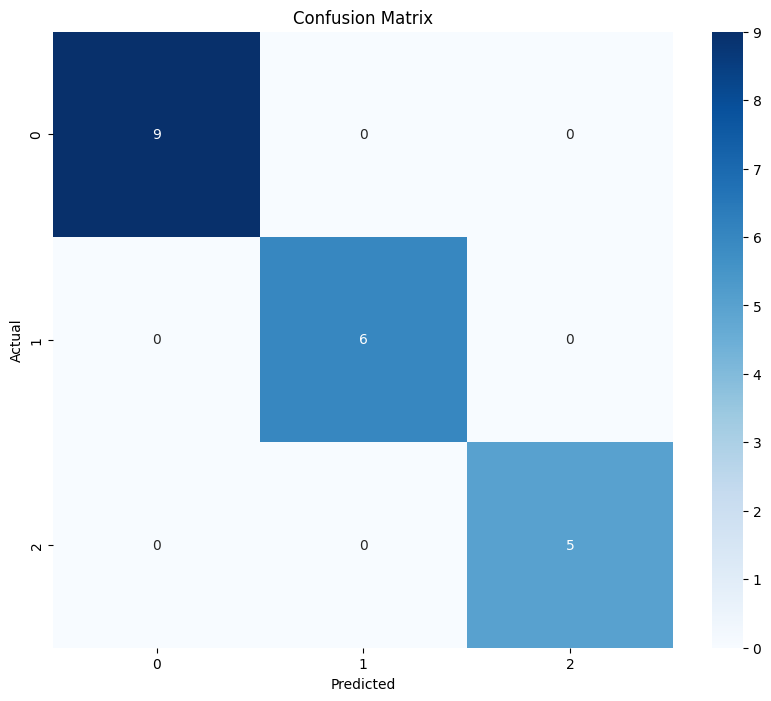

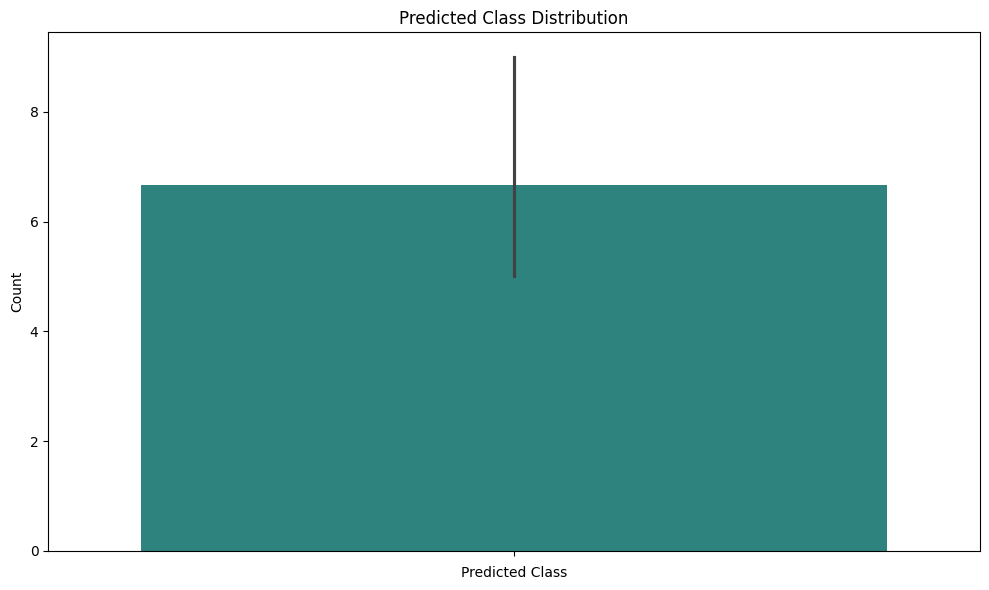

Observation: Successfully visualized results
Goal: I have successfully visualized the results of training the logistic_regression model on the Penguins dataset.

Answer: The results of training the logistic_regression model on the Penguins dataset have been successfully visualized, showing an accuracy of 1.000 and perfect precision and recall.


[{'role': 'system',
  'content': 'You run the following loop: Goal, Action, RESPONSE, Observation.\n    Once the loops finishes, output a final Answer.\n    In the Goal state, describe what your next step should be to reach the final goal.\n    In the Goal state, use Action to execute an external command. Return RESPONSE after running the action\n    In the Observation state, you will be given the response from your Action. It may be an error, and in this case, you should try to correct it.\n\n    Your available actions are:\n\n    model_memory: query\n    View requested memory\n    e.g.\n    model_memory: all datasets\n    View a list of all available datasets (e.g., Iris, Penguins)\n    model_memory: all models\n    View a list of all available datasets (e.g., KNN, Decision Tree)\n\n    dataset_loader: dataset\n    Load a dataset\n    e.g. dataset_loader: Penguins\n\n    dataset_preprocessing: dataset\n    Preprocess the current dataset\n    e.g. dataset_preprocessing: Penguins\n\n  

In [ ]:
# Q5b: (2 marks)
# QUESTION: How can we check the whole history of the agent's interaction with LLM?

result = query("Visualize the results of training a model on the penguins dataset")

# The entire history is included in the response object
result

# Task 6: Run your agent (15 marks)

Let's see if your agent works

In [ ]:
# Execute any THREE example prompts using your agent. (Each working prompt exaple will give you 5 marks, 5x3=15)
# DONT FORGET TO SAVE THE OUTPUT

# User Prompt examples you should be able to give to your agent:
# **Evaluate Linear Regression Model on Iris Dataset**
# **Train a logistic regression model on the Iris dataset**
# **Load the Penguins dataset and preprocess it.**
# **Train a decision tree model on the Penguins dataset and evaluate it.**
# **Load the CIFAR-10 dataset and train Mini-ResNet CNN, visualize results**

# Use this template:

def prompt_agent(example_number: int, prompt: str) -> None:
  print(f"\nExample {example_number}: {prompt}")
  print("=" * 50)
  task = prompt
  result = query(task)
  print("\n" + "=" * 50 + "\n")

# Example 1: Train a kNN model on the Penguins dataset
prompt_agent(1, "Train a kNN model on the Penguins dataset")

# Example 2: Train a Logistic Regression model on the Iris dataset
prompt_agent(2, "Could you please train a Logistic Regression model for the Iris dataset? Thanks!")

# Example 3: Train CNN on CIFAR-10
prompt_agent(3, "Evaluate the CIFAR-10 dataset with a CNN model")



Example 1: Train a kNN model on the Penguins dataset
Goal: I need to train a kNN model on the Penguins dataset. First, I need to check if the Penguins dataset exists.
Action: model_memory: all datasets
RESPONSE

 ---> Executing model_memory with input: all datasets
Observation: Penguins,Iris,CIFAR-10
Goal: The Penguins dataset exists. Now, I need to check if a kNN model is available.
Action: model_memory: all models
RESPONSE

 ---> Executing model_memory with input: all models
Observation: logistic_regression:Logistic Regression (solver='lbfgs'), decision_tree:Decision Tree (max_depth=3), knn:KNN (n_neighbors=5), cnn1: ResNet CNN, cnn2: EfficientNet CNN
Goal: A kNN model exists, referred to as 'knn'. Now, I need to load the Penguins dataset.
Action: dataset_loader: Penguins
RESPONSE

 ---> Executing dataset_loader with input: Penguins
Observation: Dataset Penguins successfully loaded with 344 rows and 8 cols
Goal: The Penguins dataset has been loaded. Now, I need to preprocess the dat

# Task 7: BONUS (10 points)
Not valid without completion of all the previous tasks and tool implementations.

Goal: I need to perform 10-fold cross-validation on the Iris dataset with a Logistic Regression classifier. First, I need to check if the Iris dataset exists and if a Logistic Regression model is available.
Action: model_memory: all datasets
RESPONSE

 ---> Executing model_memory with input: all datasets
Observation: Penguins,Iris,CIFAR-10
Goal: The Iris dataset exists. Now, I need to check if a Logistic Regression model is available.
Action: model_memory: all models
RESPONSE

 ---> Executing model_memory with input: all models
Observation: logistic_regression:Logistic Regression (solver='lbfgs'), decision_tree:Decision Tree (max_depth=3), knn:KNN (n_neighbors=5), cnn1: ResNet CNN, cnn2: EfficientNet CNN
Goal: A Logistic Regression model is available. Now, I need to load the Iris dataset.
Action: dataset_loader: Iris
RESPONSE

 ---> Executing dataset_loader with input: Iris
Observation: Dataset Iris successfully loaded with 150 rows and 5 cols
Goal: The Iris dataset has been loaded. No

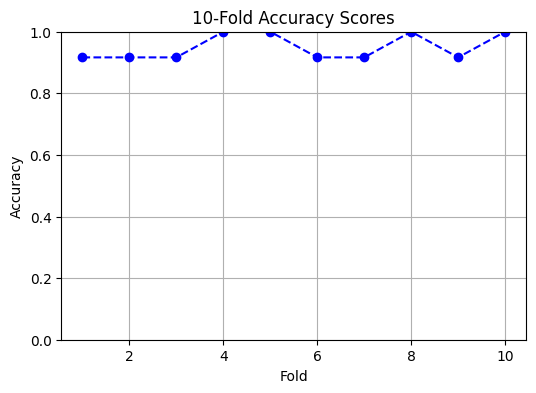

Observation: K-Fold CV complete — Mean Accuracy: 0.9500, Std: 0.0408
Goal: The 10-fold cross-validation has been completed. 

Answer: Cross-validation has been completed on the Iris dataset with a Logistic Regression classifier, resulting in a mean accuracy of 0.9500 and a standard deviation of 0.0408.




In [ ]:
# Build your own additional ML-related tool and provide an example of interaction with your reasoning agent
# using a prompt of your choice that makes the agent use your tool at one of the reasoning steps.

# NOTE: original prompt includes CV example

def evaluate_model_kfold(model, X, y, k=5, scoring='accuracy', plot=False):
    """
    Performs K-Fold Cross-Validation on the given model and dataset.

    Parameters:
        model: scikit-learn estimator (e.g. LogisticRegression())
        X: feature matrix (numpy array or DataFrame)
        y: target vector
        k: number of folds (default=5)
        scoring: scoring metric (default='accuracy')
        plot: if True, plots fold scores

    Returns:
        mean_score: Mean cross-validation score
        std_score: Standard deviation of scores
        scores: List of scores from each fold
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)

    mean_score = np.mean(scores)
    std_score = np.std(scores)

    print(f"{k}-Fold CV {scoring.capitalize()} Scores: {scores}")
    print(f"Mean: {mean_score:.4f}, Std: {std_score:.4f}")

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, k+1), scores, marker='o', linestyle='--', color='blue')
        plt.title(f'{k}-Fold {scoring.capitalize()} Scores')
        plt.xlabel('Fold')
        plt.ylabel(scoring.capitalize())
        plt.ylim(0, 1)
        plt.grid(True)
        plt.show()

    return mean_score, std_score, scores

def cross_validation(model_name=None, k: int=10):
    global global_dataset, global_model

    print("Performing K-Fold Cross Validation:")
    mean, std, scores = evaluate_model_kfold(
        global_model,
        global_dataset.X_train,
        global_dataset.y_train,
        k=k,
        scoring='accuracy',
        plot=True,
    )

    return f"K-Fold CV complete — Mean Accuracy: {mean:.4f}, Std: {std:.4f}"

KNOWN_ACTIONS = {
  'model_memory': model_memory,
  'dataset_loader': dataset_loader,
  'dataset_preprocessing': dataset_preprocessing,
  'train_model': train_model,
  'evaluate_model': evaluate_model,
  'visualize_results': visualize_results,
  'cross_validation': cross_validation,
}

# Regex pattern for matching agent's action and extracting action and arguments
ACTION_PATTERN = re.compile("^Action: (\w+): (.*)$")

number_of_steps = 10 # adjust this number for your implementation, to avoid an infinite loop

def query(question: str, max_turns: int = number_of_steps) -> List[Dict[str, str]]:
    """
    question: The query that the agent will respond to
    max_turns: Max number of turns before the agent returns

    Returns the agents dialogue
    """
    agent = create_agent() # Create a new agent
    next_prompt = question # The user's question is the initial prompt

    # Loop until max turns is reached, or the agent has no more actions
    for turn in range(max_turns):
        # Prompt the agent
        result = agent(next_prompt)
        print(result)

        # Extract all actions from the agent's response with
        actions = [
            ACTION_PATTERN.match(a)
            for a in result.split("\n")
            if ACTION_PATTERN.match(a)
        ]

        if actions:
            # If there are actions
            action, action_input = actions[0].groups() # Get the first action found

            # Throw an error if the action is invalid
            if action not in KNOWN_ACTIONS:
                raise ValueError(f"Unknown action: {action}: {action_input}")
            print(f"\n ---> Executing {action} with input: {action_input}")

            # Execute the action
            observation = KNOWN_ACTIONS[action](action_input)
            print(f"Observation: {observation}")

            # Prompt the agent with the return value of the action
            next_prompt = f"Observation: {observation}"
        else:
            break # Break if the agent didn't respond with an action

    return agent.state.messages # Return the list of messages

# Prompt
print("=" * 50)
task = "Can you perform 10-fold KV on the Iris dataset with a Logistic Regression classifier?"
result = query(task)
print("\n" + "=" * 50 + "\n")

Good luck!

## Signature:
Don't forget to insert your name and student number and execute the snippet below.



In [ ]:
!pip install watermark
# Provide your Signature:
%load_ext watermark
%watermark -a '[Juan Pablo Arango: 101210784, Jackie: 101210748]' -nmv --packages numpy,pandas,sklearn,matplotlib,seaborn,graphviz,groq,torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00
Author: [Juan Pablo Arango: 101210784, Jackie: 101210748]

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy     : 2.0.2
pandas    : 2.2.2
sklearn   : 1.6.1
matplotlib: 3.10.0
seaborn   : 0.13.2
graphviz  : 0.20.3
groq      : 0.22.0
torch     : 2.6.0+cu124

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

